In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, PolynomialFeatures, QuantileTransformer
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score


In [3]:
# For deep learning models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import get_custom_objects


In [4]:
from tpot import TPOTClassifier


In [5]:
 #For handling imbalance
from imblearn.over_sampling import ADASYN


In [6]:
data = pd.read_csv('anemia (1).csv')
print("Dataset Info:\n")
data.info()


Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1421 entries, 0 to 1420
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Gender      1421 non-null   int64  
 1   Hemoglobin  1421 non-null   float64
 2   MCH         1421 non-null   float64
 3   MCHC        1421 non-null   float64
 4   MCV         1421 non-null   float64
 5   Result      1421 non-null   int64  
dtypes: float64(4), int64(2)
memory usage: 66.7 KB


In [7]:
print("\nDescriptive Statistics:\n")
print(data.describe())




Descriptive Statistics:

            Gender   Hemoglobin          MCH         MCHC          MCV  \
count  1421.000000  1421.000000  1421.000000  1421.000000  1421.000000   
mean      0.520760    13.412738    22.905630    30.251232    85.523786   
std       0.499745     1.974546     3.969375     1.400898     9.636701   
min       0.000000     6.600000    16.000000    27.800000    69.400000   
25%       0.000000    11.700000    19.400000    29.000000    77.300000   
50%       1.000000    13.200000    22.700000    30.400000    85.300000   
75%       1.000000    15.000000    26.200000    31.400000    94.200000   
max       1.000000    16.900000    30.000000    32.500000   101.600000   

            Result  
count  1421.000000  
mean      0.436312  
std       0.496102  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       1.000000  
max       1.000000  


/var/folders/x4/hf122vdn1lqg1txf67c39vmw0000gn/T/ipykernel_1756/1405645065.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Result', data=data, palette='pastel')


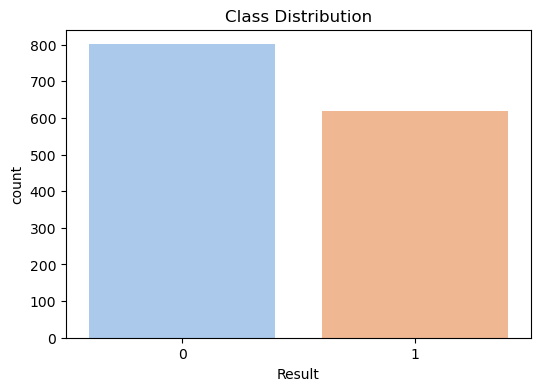

In [8]:
# Class distribution before resampling
plt.figure(figsize=(6, 4))
sns.countplot(x='Result', data=data, palette='pastel')
plt.title('Class Distribution')
plt.show()


In [9]:
# Select features & target
selected_features = ['Hemoglobin', 'MCH', 'MCHC', 'MCV']
X_selected = data[selected_features]
y = data['Result']


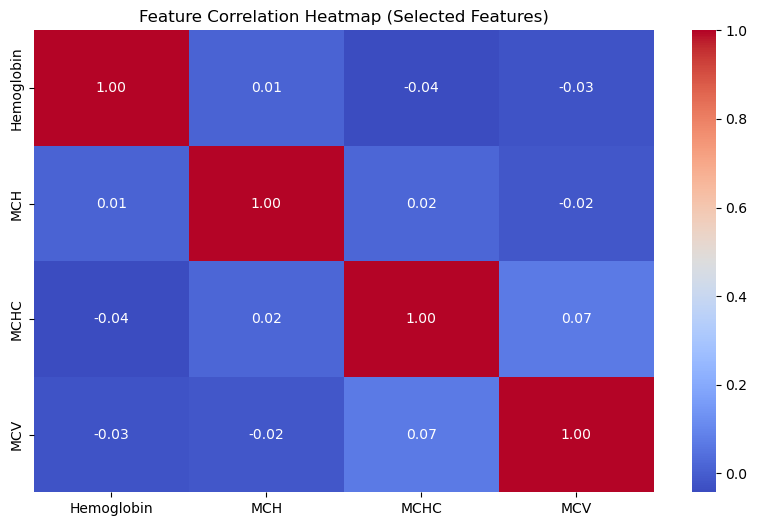

In [10]:
# Visualize correlation for selected features
plt.figure(figsize=(10, 6))
sns.heatmap(X_selected.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Heatmap (Selected Features)')
plt.show()


In [11]:
# Polynomial Features (interaction terms)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_selected)
# (Note: In the following models, we will use X_selected features after scaling.
# You can experiment with X_poly if the interactions are relevant.)


In [12]:
# Quantile-based scaling: transform features to be normally distributed
scaler = QuantileTransformer(output_distribution='normal', random_state=42)
X_scaled = scaler.fit_transform(X_selected)


In [13]:
# Apply ADASYN over-sampling to balance the classes
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X_scaled, y)


/var/folders/x4/hf122vdn1lqg1txf67c39vmw0000gn/T/ipykernel_1756/2943700791.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled, palette='pastel')


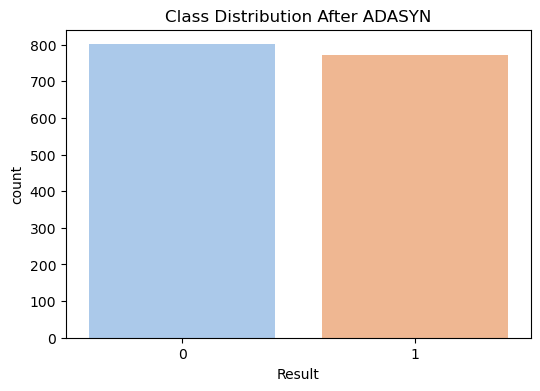

In [14]:
# Class distribution after resampling
plt.figure(figsize=(6, 4))
sns.countplot(x=y_resampled, palette='pastel')
plt.title('Class Distribution After ADASYN')
plt.show()


In [15]:
# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)


In [16]:
# -------------------------------------
# 1. Artificial Neural Network (ANN)
# -------------------------------------
print("Training ANN Model...")
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input

ann_model = Sequential([
    Input(shape=(X_train.shape[1],)),        # ✅ Define input shape here
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

ann_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

ann_history = ann_model.fit(X_train, y_train, epochs=50, batch_size=32,
                            validation_split=0.1, verbose=0)



Training ANN Model...


In [17]:
# Evaluate ANN
y_pred_ann_prob = ann_model.predict(X_test)
y_pred_ann = (y_pred_ann_prob > 0.5).astype(int)
print("ANN Classification Report:")
print(classification_report(y_test, y_pred_ann))
print(accuracy_score(y_test, y_pred_ann))


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
ANN Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.86      0.92       161
           1       0.87      0.98      0.92       154

    accuracy                           0.92       315
   macro avg       0.93      0.92      0.92       315
weighted avg       0.93      0.92      0.92       315

0.9206349206349206


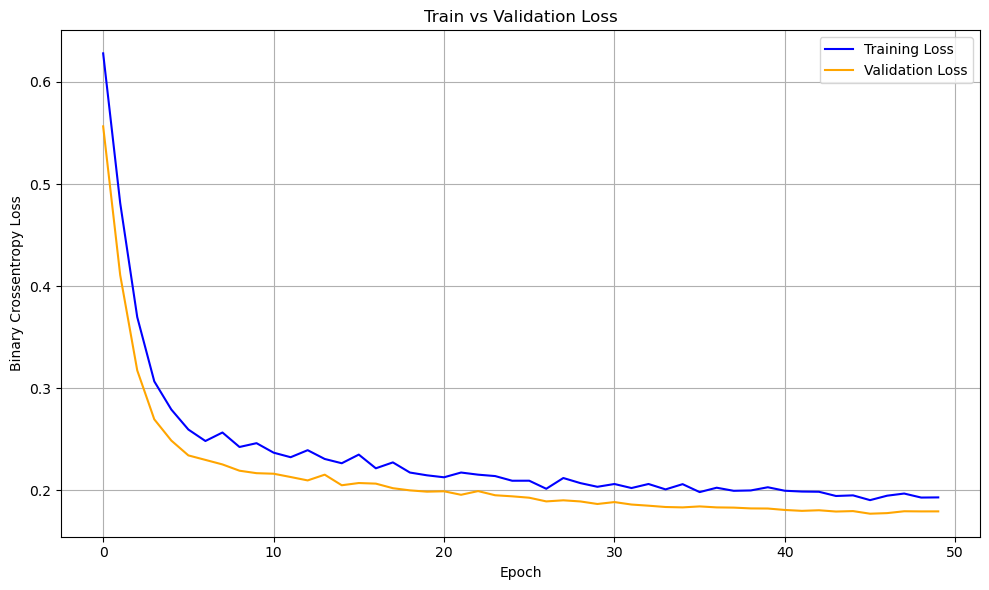

In [41]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(ann_history.history['loss'], label='Training Loss', color='blue')
plt.plot(ann_history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Train vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

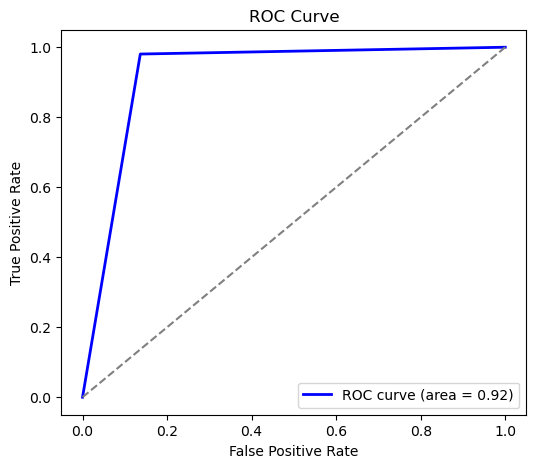

In [49]:
if y_test_proba is not None:
    fpr, tpr, _ = roc_curve(y_test, y_pred_ann)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show() 

In [18]:
# -------------------------------------
# Preparing Data for Sequential Models
# -------------------------------------
# For LSTM and GRU we need a 3D input: (samples, timesteps, features).
# Since we have tabular data, we use timesteps = 1.
X_train_seq = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_seq = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))



In [19]:
# ------------------------
# 2. LSTM Model
# ------------------------
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input

lstm_model = Sequential([
    Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2])),  # ✅ Input shape here
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(optimizer=Adam(learning_rate=0.001),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

lstm_history = lstm_model.fit(X_train_seq, y_train, epochs=50, batch_size=32,
                              validation_split=0.1, verbose=0)



In [20]:
# Evaluate LSTM
y_pred_lstm_prob = lstm_model.predict(X_test_seq)
y_pred_lstm = (y_pred_lstm_prob > 0.5).astype(int)
print("LSTM Classification Report:")
print(classification_report(y_test, y_pred_lstm))
print(accuracy_score(y_test, y_pred_lstm))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.84      0.90       161
           1       0.85      0.98      0.91       154

    accuracy                           0.91       315
   macro avg       0.92      0.91      0.91       315
weighted avg       0.92      0.91      0.91       315

0.9079365079365079


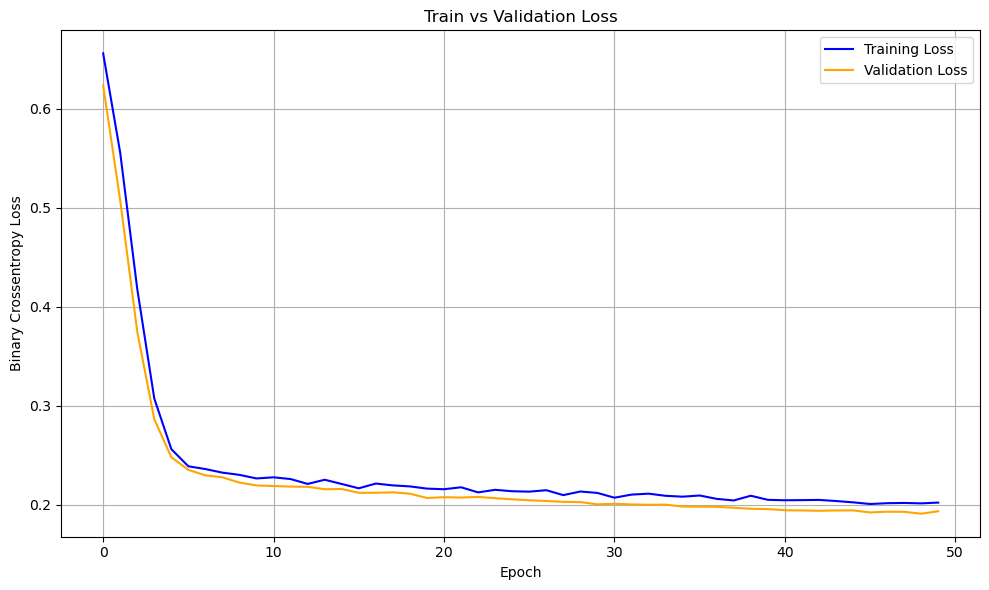

In [39]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(lstm_history.history['loss'], label='Training Loss', color='blue')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Train vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

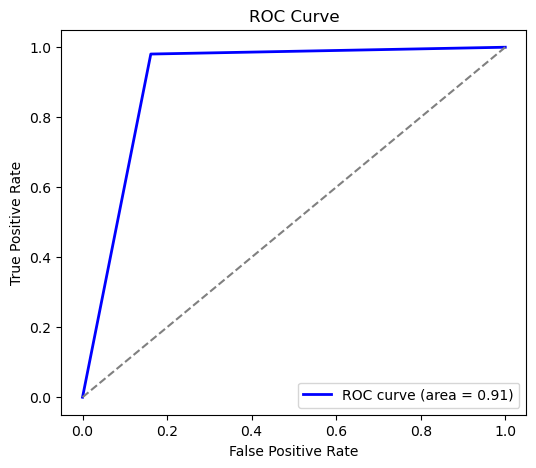

In [47]:
if y_test_proba is not None:
    fpr, tpr, _ = roc_curve(y_test,  y_pred_lstm)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show() 

In [21]:
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout, Input

gru_model = Sequential([
    Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2])),  # ✅ Clean input declaration
    GRU(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
gru_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

history = gru_model.fit(X_train_seq, y_train, epochs=50, batch_size=32,
                            validation_split=0.1, verbose=0)



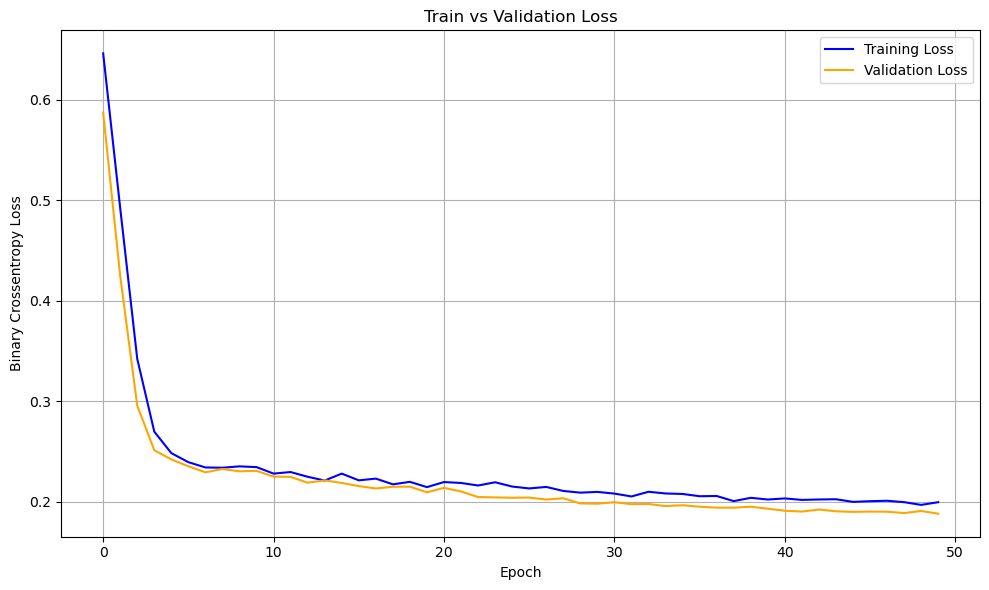

In [37]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Train vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
# Evaluate GRU
y_pred_gru_prob = gru_model.predict(X_test_seq)
y_pred_gru = (y_pred_gru_prob > 0.5).astype(int)
print("GRU Classification Report:")
print(classification_report(y_test, y_pred_gru))
print(accuracy_score(y_test, y_pred_gru))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
GRU Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.85      0.90       161
           1       0.86      0.97      0.91       154

    accuracy                           0.91       315
   macro avg       0.91      0.91      0.91       315
weighted avg       0.91      0.91      0.91       315

0.9079365079365079


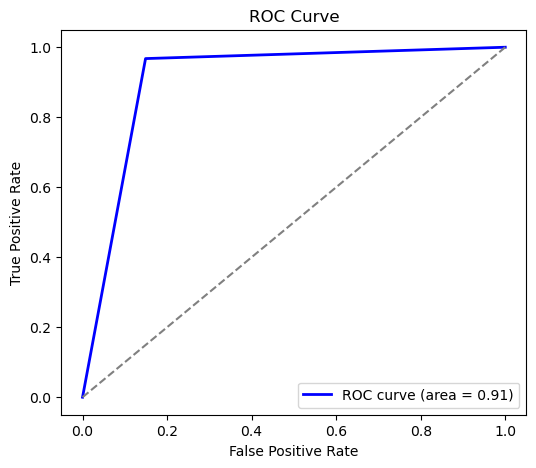

In [51]:
if y_test_proba is not None:
    fpr, tpr, _ = roc_curve(y_test, y_pred_gru)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

In [23]:
# ------------------------
# 4. TPOT AutoML Pipeline
# ------------------------
print("Training TPOT Classifier...")
# Note: TPOT may take longer depending on your computational resources.
tpot = TPOTClassifier(generations=5, population_size=20, random_state=42)
tpot.fit(X_train, y_train)
y_pred_tpot = tpot.predict(X_test)
print("TPOT Classification Report:")
print(classification_report(y_test, y_pred_tpot))
print("TPOT Accuracy Score:", accuracy_score(y_test, y_pred_tpot))



Training TPOT Classifier...


/opt/anaconda3/lib/python3.12/site-packages/tpot/tpot_estimator/estimator.py:456: UserWarning: Both generations and max_time_mins are set. TPOT will terminate when the first condition is met.
  warnings.warn("Both generations and max_time_mins are set. TPOT will terminate when the first condition is met.")
Generation: 100%|█████████████████████████████████| 5/5 [01:51<00:00, 22.22s/it]


TPOT Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       161
           1       0.98      0.99      0.98       154

    accuracy                           0.98       315
   macro avg       0.98      0.98      0.98       315
weighted avg       0.98      0.98      0.98       315

TPOT Accuracy Score: 0.9841269841269841


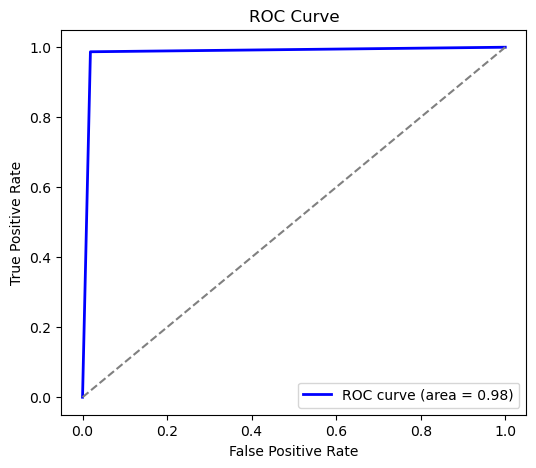

In [53]:
if y_test_proba is not None:
    fpr, tpr, _ = roc_curve(y_test, y_pred_tpot)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

In [24]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Extract the best pipeline from TPOT (already fitted)
best_pipeline = tpot.fitted_pipeline_

# Initialize Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform Stratified K-Fold cross-validation
skf_scores = cross_val_score(best_pipeline, X_train, y_train, cv=skf, scoring='accuracy')

# Output results
print("Stratified K-Fold Cross Validation Scores: ", skf_scores)
print("Mean Stratified K-Fold Score: ", skf_scores.mean())

Stratified K-Fold Cross Validation Scores:  [0.97222222 0.96825397 0.99203187 0.99601594 0.99601594]
Mean Stratified K-Fold Score:  0.9849079870992222


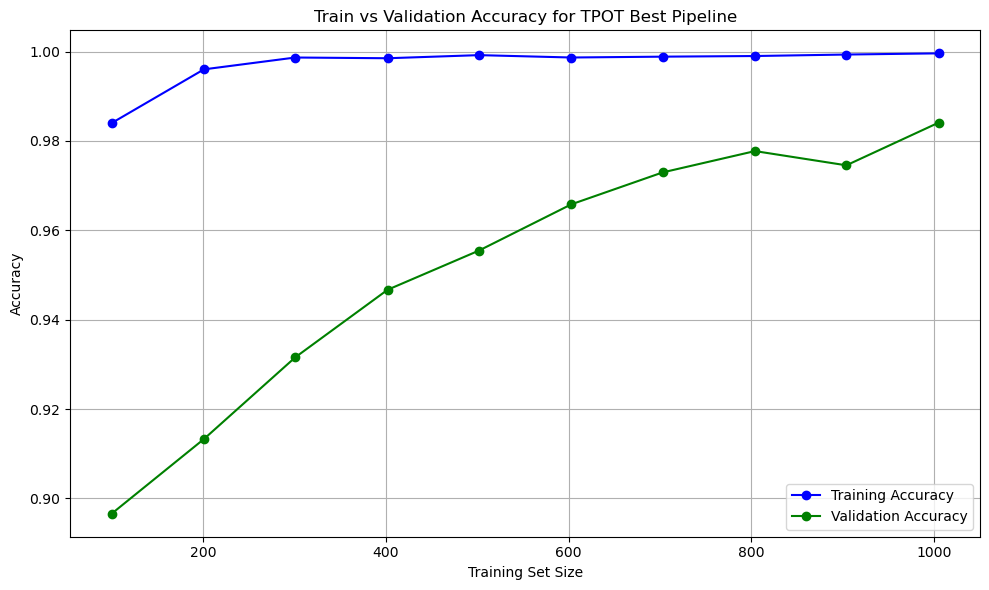

In [25]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, val_scores = learning_curve(
    best_pipeline, X_train, y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, random_state=42
)

# Compute means and standard deviations
train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training Accuracy')
plt.plot(train_sizes, val_scores_mean, 'o-', color='green', label='Validation Accuracy')
plt.title('Train vs Validation Accuracy for TPOT Best Pipeline')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


rbm = BernoulliRBM(random_state=42, n_iter=20, n_components=256)
logistic = LogisticRegression(max_iter=1000, random_state=42)
classifier = Pipeline(steps=[('rbm', rbm), ('logistic', logistic)])

# Train the model
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
y_prob = classifier.predict_proba(X_test)[:, 1]

# Evaluate the model
roc_score = roc_auc_score(y_test, y_prob)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_score)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.60      0.63       161
           1       0.62      0.68      0.65       154

    accuracy                           0.64       315
   macro avg       0.64      0.64      0.64       315
weighted avg       0.64      0.64      0.64       315

ROC AUC Score: 0.7381221263208841
Accuracy: 0.638095238095238


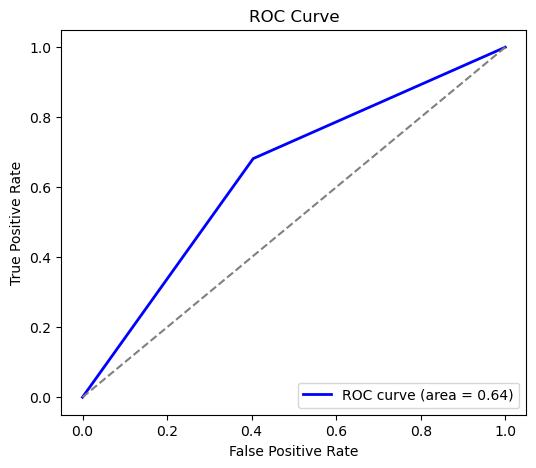

In [55]:
if y_test_proba is not None:
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

In [27]:
!pip install lime


In [28]:
import warnings

warnings.filterwarnings("ignore")

from lime import lime_tabular

# Convert X_test to a DataFrame with appropriate column names
X_test_df = pd.DataFrame(X_test, columns=X_selected.columns)

# Create LIME explainer
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=X_selected.columns.tolist(),
    class_names=['Not Anemic', 'Anemic'],  # Adjust according to your target class names
    mode='classification'
)

# Choose the model for explanation – e.g., TPOT's best pipeline
best_model = tpot.fitted_pipeline_  # If using TPOT
# Or ann_model.predict if you want to use ANN model

# Generate explanation for the first test instance
exp = explainer.explain_instance(
    data_row=X_test_df.iloc[0],
    predict_fn=best_model.predict_proba
)

# Show explanation
exp.show_in_notebook()


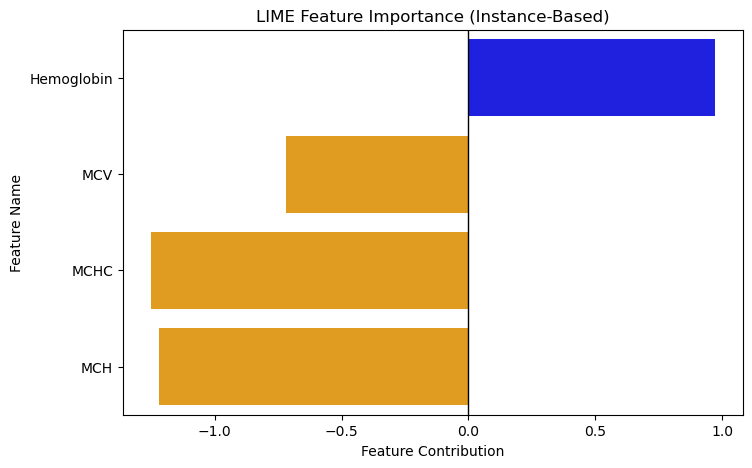

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data from the image
features = ['Hemoglobin', 'MCV', 'MCHC', 'MCH']
values = [0.97, -0.72, -1.25, -1.22]

# Set figure size
plt.figure(figsize=(8, 5))

# Color based on value: Orange for negative, Blue for positive
colors = ["orange" if v < 0 else "blue" for v in values]

# Create bar plot
sns.barplot(x=values, y=features, palette=colors)

# Add labels and title
plt.xlabel("Feature Contribution")
plt.ylabel("Feature Name")
plt.title("LIME Feature Importance (Instance-Based)")

# Add vertical reference line at zero
plt.axvline(0, color="black", linewidth=1)

# Show plota
plt.show()

In [30]:
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, roc_curve, auc
y_train_pred = best_pipeline.predict(X_train)
y_test_pred = best_pipeline.predict(X_test)

# Get predicted probabilities for ROC curve
y_test_proba = best_pipeline.predict_proba(X_test)[:, 1] if hasattr(best_pipeline, "predict_proba") else None

# Compute accuracy and log loss
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_loss = log_loss(y_train, best_pipeline.predict_proba(X_train)) if hasattr(best_pipeline, "predict_proba") else None
test_loss = log_loss(y_test, best_pipeline.predict_proba(X_test)) if hasattr(best_pipeline, "predict_proba") else None

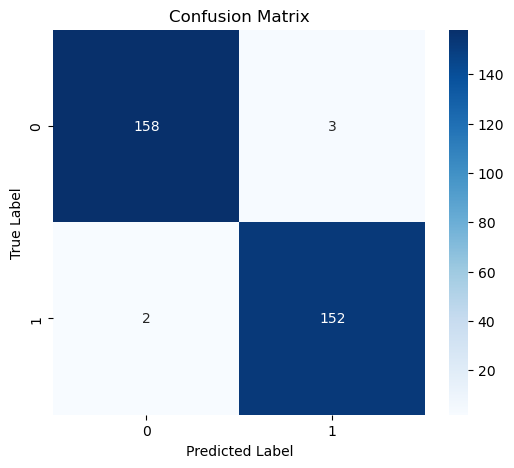

In [31]:
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

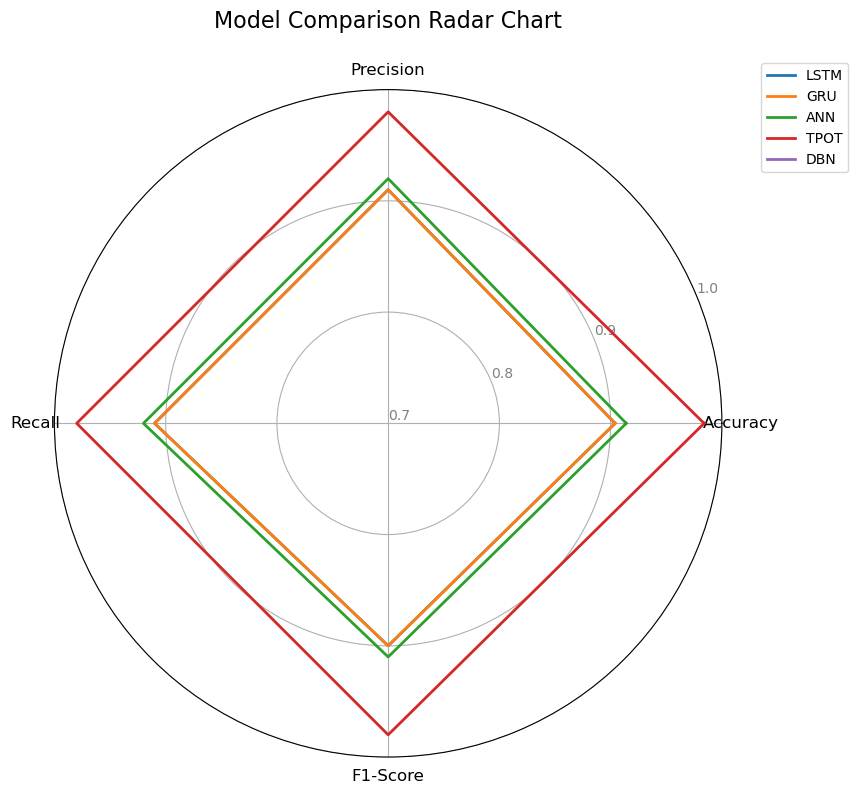

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Define model names
models = ['LSTM', 'GRU', 'ANN', 'TPOT', 'DBN']

# Example metric values (Replace with actual values from your evaluation)
# Order of metrics: [Accuracy, Precision, Recall, F1-score]
model_scores = {
    'LSTM': [0.904, 0.91, 0.91, 0.90],
    'GRU':  [0.904, 0.91, 0.91, 0.90],
    'ANN':  [0.914, 0.92, 0.92, 0.91],
    'TPOT': [0.984, 0.98, 0.98, 0.98],
    'DBN':  [0.638, 0.64, 0.64, 0.64]
}

# Labels for the axes
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
num_metrics = len(metrics)

# Angles for each axis in the radar chart
angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
angles += angles[:1]  # Close the loop

# Plot radar chart
plt.figure(figsize=(10, 8))
for model in models:
    values = model_scores[model]
    values += values[:1]  # Close the loop
    plt.polar(angles, values, label=model, linewidth=2)

# Draw metric labels
plt.xticks(angles[:-1], metrics, fontsize=12)
plt.title('Model Comparison Radar Chart', size=16, y=1.08)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.05))
plt.yticks([0.7, 0.8, 0.9, 1.0], color='gray', size=10)
plt.ylim(0.7, 1.0)
plt.grid(True)
plt.tight_layout()
plt.show()